<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Предварительный-вывод-№1" data-toc-modified-id="Предварительный-вывод-№1-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Предварительный вывод №1</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Предварительный-вывод-№2" data-toc-modified-id="Предварительный-вывод-№2-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Предварительный вывод №2</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
#!pip install ydata_profiling
#!pip install lightgbm
#!pip install catboost

In [2]:
import pandas as pd
import numpy as np 
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from math import sqrt

from ydata_profiling import ProfileReport
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

RANDOM_SEED = 1234

## Подготовка

In [3]:
try:
    taxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
taxi.sort_index(inplace=True)

In [6]:
taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


## Анализ

In [7]:
profile = ProfileReport(taxi)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
taxi.index.is_monotonic

True

In [9]:
taxi = taxi.resample('1h').sum()

In [10]:
print(taxi.index.min())
print(taxi.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


In [11]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


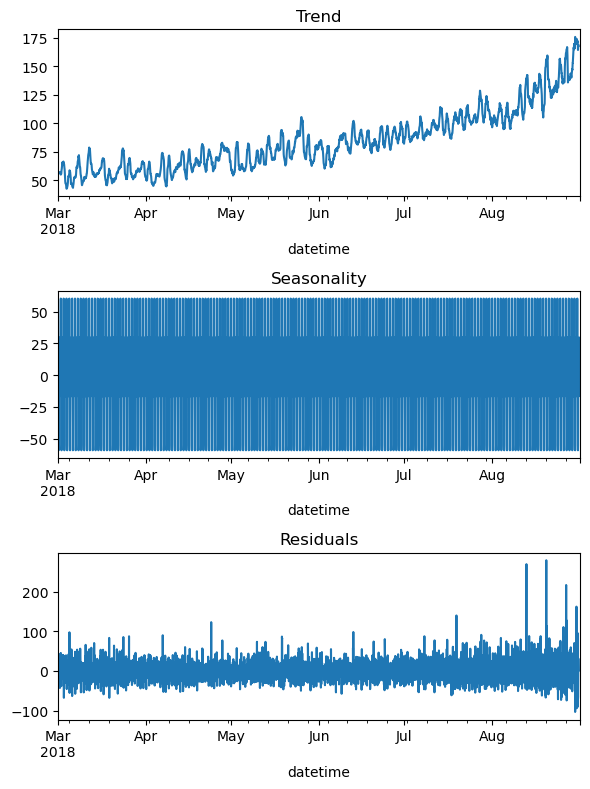

In [12]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()
plt.show()

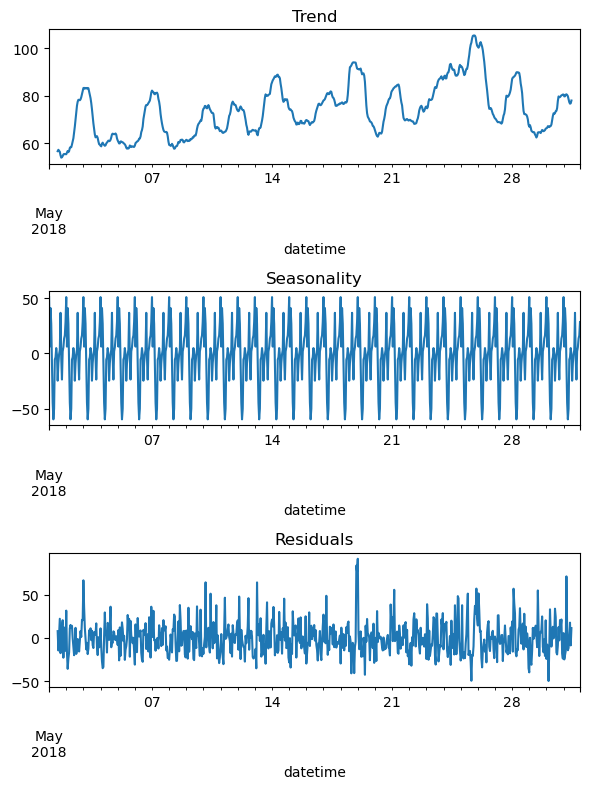

In [13]:
decomposed = seasonal_decompose(taxi['2018-05':'2018-05'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()
plt.show()

In [14]:
ts = taxi['num_orders']
st_test = adfuller(ts, regression='ctt')
if st_test[1] < 0.05: print('Временной ряд стационарный')
else: print('Временной ряд не стационарный')

Временной ряд стационарный


#### Предварительный вывод №1

В качестве данных для прогнозирования заказов такси представлены данные о количестве заказов с 01.03.2018 по 31.08.2018. Данные сгруппированы с интервалом 10 минут. Данные без пробелов в интервалах. Выполнено было ресемплирование на интервалы по 1 часу. При анализе выявлен тренд на повышение количества поездок, сезонность не выявлена, при оценке данных за месяц (май 2018) закономерности не изменились.
Выполнена проверка на стационарность временного ряда. Использовался метод расширенный тест Дики-Фуллера, в котором используются следующие нулевая и альтернативная гипотезы:
H 0 : Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.
H A : временной ряд является стационарным.
Если p-значение из теста меньше некоторого уровня значимости (в этом случае, α = 0,05), то мы можем отвергнуть нулевую гипотезу и сделать вывод, что временной ряд является стационарным.

In [15]:
def make_features(taxi, max_lag, rolling_mean_size):
    taxi_dub = taxi.copy()
    taxi_dub['month'] = taxi.index.month
    taxi_dub['day'] = taxi.index.day
    taxi_dub['dayofweek'] = taxi.index.dayofweek

    for lag in range(1, max_lag + 1):
        taxi_dub['lag_{}'.format(lag)] = taxi_dub['num_orders'].shift(lag)

    taxi_dub['rolling_mean'] = taxi_dub['num_orders'].shift().rolling(rolling_mean_size).mean()
    taxi_dub = taxi_dub.dropna()
    return taxi_dub

taxi_dub = make_features(taxi, 168, 6)
print(taxi_dub)

                     num_orders  month  day  dayofweek  lag_1  lag_2  lag_3  \
datetime                                                                      
2018-03-08 00:00:00         143      3    8          3   94.0  127.0  108.0   
2018-03-08 01:00:00          78      3    8          3  143.0   94.0  127.0   
2018-03-08 02:00:00          65      3    8          3   78.0  143.0   94.0   
2018-03-08 03:00:00          68      3    8          3   65.0   78.0  143.0   
2018-03-08 04:00:00          60      3    8          3   68.0   65.0   78.0   
...                         ...    ...  ...        ...    ...    ...    ...   
2018-08-31 19:00:00         136      8   31          4  207.0  217.0  197.0   
2018-08-31 20:00:00         154      8   31          4  136.0  207.0  217.0   
2018-08-31 21:00:00         159      8   31          4  154.0  136.0  207.0   
2018-08-31 22:00:00         223      8   31          4  159.0  154.0  136.0   
2018-08-31 23:00:00         205      8   31         

C:\Users\mamon\AppData\Local\Temp\ipykernel_6400\1040691818.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  taxi_dub['lag_{}'.format(lag)] = taxi_dub['num_orders'].shift(lag)
C:\Users\mamon\AppData\Local\Temp\ipykernel_6400\1040691818.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  taxi_dub['lag_{}'.format(lag)] = taxi_dub['num_orders'].shift(lag)
C:\Users\mamon\AppData\Local\Temp\ipykernel_6400\1040691818.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

При создании признаков формируем отстающие значения с учётом вероятных недельных циклов вызовов такси (168  часов) и скользящее среднее за 6-часовой интервал.

In [16]:
X = taxi_dub.drop(['num_orders'], axis=1)
y = taxi_dub['num_orders']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.1, shuffle=False, random_state=RANDOM_SEED)

## Обучение

In [18]:
tscv = TimeSeriesSplit()

In [19]:
model_1 = LinearRegression()
params_1 = {}
search_1 = GridSearchCV(model_1, params_1, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')
search_1.fit(X_train, y_train)
best_m_1 = search_1.best_estimator_
print(search_1.best_score_ * -1)

22.72549435930253


In [20]:
model_2 = LGBMRegressor()
params_2 = {'n_estimators': range(100, 250, 50), 'max_depth': range(3, 13, 2), 'learning_rate': [0.01, 0.05, 0.1]}
search_2 = GridSearchCV(model_2, params_2, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')
search_2.fit(X_train, y_train)
best_m_2 = search_2.best_estimator_
print(search_2.best_params_)
print(search_2.best_score_ * -1)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31602
[LightGBM] [Info] Number of data points in the train set: 3823, number of used features: 172
[LightGBM] [Info] Start training from score 79.561601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [21]:
model_3 = CatBoostRegressor(loss_function='RMSE', learning_rate=0.1)
params_3 = {'iterations': [100, 500, 1000], 'depth': [4, 6, 8]}
search_3 = GridSearchCV(model_3, params_3, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')
search_3.fit(X_train, y_train)
best_m_3 = search_3.best_estimator_
print(search_3.best_params_)
print(search_3.best_score_ * -1)

0:	learn: 36.8856354	total: 141ms	remaining: 14s
1:	learn: 35.2271939	total: 147ms	remaining: 7.21s
2:	learn: 33.6492623	total: 152ms	remaining: 4.93s
3:	learn: 32.1085488	total: 159ms	remaining: 3.82s
4:	learn: 30.8875585	total: 165ms	remaining: 3.14s
5:	learn: 29.7645995	total: 171ms	remaining: 2.69s
6:	learn: 28.7070634	total: 178ms	remaining: 2.36s
7:	learn: 27.9469035	total: 183ms	remaining: 2.11s
8:	learn: 27.1072659	total: 189ms	remaining: 1.91s
9:	learn: 26.5285832	total: 195ms	remaining: 1.75s
10:	learn: 25.8986424	total: 200ms	remaining: 1.62s
11:	learn: 25.2919079	total: 206ms	remaining: 1.51s
12:	learn: 24.7916257	total: 212ms	remaining: 1.42s
13:	learn: 24.3687773	total: 217ms	remaining: 1.33s
14:	learn: 23.9653950	total: 223ms	remaining: 1.26s
15:	learn: 23.6632634	total: 228ms	remaining: 1.2s
16:	learn: 23.3664669	total: 234ms	remaining: 1.14s
17:	learn: 23.1036695	total: 239ms	remaining: 1.09s
18:	learn: 22.8893560	total: 245ms	remaining: 1.04s
19:	learn: 22.7054701	tot

#### Предварительный вывод №2

Были обучены с оптимальным подбором гиперпараметров три модели: LinearRegression, LGBMRegressor и CatBoostRegressor. Лучший результат показала модель CatBoostRegressor с результатом метрики RMSE 22.52261133178001. 

## Тестирование

In [22]:
pred_t = best_m_3.predict(X_test)
print("RMSE тестовой выборки:", sqrt(mean_squared_error(pred_t, y_test)))

RMSE тестовой выборки: 37.07105723496767


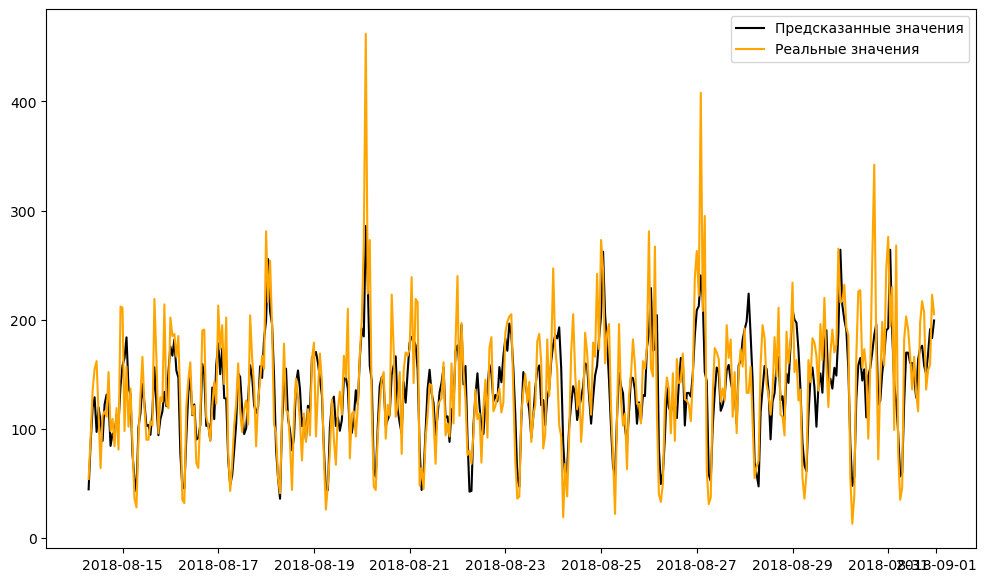

In [23]:
plt.figure(figsize=(12, 7))
plt.plot(y_test.index, pred_t, color='black', label='Предсказанные значения')
plt.plot(y_test.index, y_test, color='orange', label='Реальные значения')
plt.legend()
plt.show()

### Вывод

Была поставлена задача предсказания количества вызовов такси в следующий час. Для обучения и тестирования моделей использовались данные, собранные с 01.03.2018 по 31.08.18 Данные были исследованы, сформированы новые признаки. Были обучены с оптимальным подбором гиперпараметров три модели: LinearRegression, LGBMRegressor и CatBoostRegressor. Лучший результат на тренировочной выборке показала модель CatBoostRegressor с результатом метрики RMSE 22.52261133178001. На тестовой выборке эта модель показала метрику RMSE = 37.07105723496767. Целевое качество модели было достигнуто.